<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/3_dimensionality_reduction_using_unsupervised_pretrained_stacked_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality reduction using Unsupervised Pretrained Stacked Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com/, a website that shows faces generated by a recent GAN architecture called StyleGAN (you can also check out https://thisrentaldoesnotexist.com/ to see some generated Airbnb bedrooms).

GANs are now widely used for super resolution (increasing the resolution of
an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models and strengthening them, and more.

Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications.

However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

* GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake.

We will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will start by building a simple GAN to generate fake images, but we will see that training is often quite difficult.



## Use-case

If you are tackling a complex supervised task but you do not have a lot of labeled training data, one solution is to find a neural network that
performs a similar task and reuse its lower layers. This makes it possible to train a high-performance model using little training data because your neural network won’t have to learn all the low-level features; it will just reuse the feature detectors learned by the existing network. 

Similarly, if you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task and train it using the labeled data.

For example, It shows how to use a stacked autoencoder to perform unsupervised pretraining for a classification neural network. When training the classifier, if you really don’t have much labeled training data, you may want to freeze the pretrained layers (at least the lower ones).

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/unsupervised-pretraining-autoencoders.png?raw=1' width='800'/>

Having plenty of unlabeled data and little labeled data is common.
Building a large unlabeled dataset is often cheap (e.g., a simple
script can download millions of images off the internet), but labeling
those images (e.g., classifying them as cute or not) can usually
be done reliably only by humans. Labeling instances is timeconsuming
and costly, so it’s normal to have only a few thousand human-labeled instances.

There is nothing special about the implementation: just train an autoencoder using all the training data (labeled plus unlabeled), then reuse its encoder layers to create a new neural network.


## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


A couple utility functions to plot grayscale 28x28 image:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Tying Weights

When an autoencoder is neatly symmetrical, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers.
This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. 

Specifically, if the autoencoder has a total of N layers (not counting the input layer), and WL represents the connection weights of the Lth layer
(e.g., layer 1 is the first hidden layer, layer N/2 is the coding layer, and layer N is the output layer), then the decoder layer weights can be defined simply as: 

$$WN–L+1 = WL⊺$$ (with L = 1, 2, …, N/2).

To tie weights between layers using Keras, let’s define a custom layer:

In [0]:
class DenseTranspose(keras.layers.Layer):

  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.biases = self.add_weight(name='bias', shape=[self.dense.input_shape[-1]], initializer='zeros')
    super().build(batch_input_shape)

  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

This custom layer acts like a regular Dense layer, but it uses another Dense layer’s weights, transposed (setting transpose_b=True is equivalent to transposing the second argument, but it’s more efficient as it performs the transposition on the fly within the matmul() operation). However, it uses its own bias vector.


Let's load MNIST dataset.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


Next, we can build a new stacked autoencoder, much like the previous one, but with the decoder’s Dense layers tied to the encoder’s Dense layers:

In [0]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [7]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

# split the autoencoder model into two submodels: the encoder and the decoder.
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784
    dense_1,    
    dense_2
])
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),  # decoder takes codings of size 30 (output by the encoder)
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

tied_autoencoder = keras.models.Sequential([tied_encoder, tied_decoder])
tied_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = tied_autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 10s 175us/sample - loss: 0.3268 - rounded_accuracy: 0.8960 - val_loss: 0.3024 - val_rounded_accuracy: 0.9207
Epoch 2/20
55000/55000 [==============================] - 7s 135us/sample - loss: 0.2974 - rounded_accuracy: 0.9225 - val_loss: 0.2974 - val_rounded_accuracy: 0.9271
Epoch 3/20
55000/55000 [==============================] - 7s 132us/sample - loss: 0.2918 - rounded_accuracy: 0.9277 - val_loss: 0.2963 - val_rounded_accuracy: 0.9264
Epoch 4/20
55000/55000 [==============================] - 7s 134us/sample - loss: 0.2889 - rounded_accuracy: 0.9303 - val_loss: 0.2899 - val_rounded_accuracy: 0.9321
Epoch 5/20
55000/55000 [==============================] - 7s 133us/sample - loss: 0.2867 - rounded_accuracy: 0.9322 - val_loss: 0.2868 - val_rounded_accuracy: 0.9336
Epoch 6/20
55000/55000 [==============================] - 7s 133us/sample - loss: 0.2851 - rounded_accuracy: 0.9337 - va

## Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. 

Let’s plot a few images from the validation set, as well as their reconstructions:

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

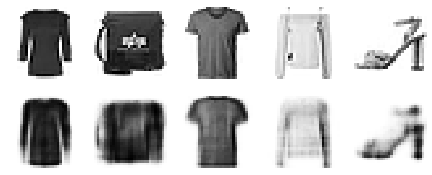

In [12]:
show_reconstructions(tied_autoencoder)

This model achieves a very slightly lower reconstruction error than the previous model, with almost half the number of parameters.

## Training One Autoencoder at a Time

Rather than training the whole stacked autoencoder in one go like we just did, it is possible to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder.

This technique is not used as much these days, but you may still run into papers that talk about “greedy layerwise training,” so it’s good to know what it means.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/one-autoencoder-at-a-time.png?raw=1' width='800'/>

During the first phase of training, the first autoencoder learns to reconstruct the inputs. Then we encode the whole training set using this first autoencoder, and this gives us a new (compressed) training set. We then train a second autoencoder on this new dataset. This is the second phase of training. Finally, we build a big sandwich using all these autoencoders.

We first stack the hidden layers of each autoencoder, then the output layers in reverse order. This gives us the final stacked autoencoder.

We could easily train more autoencoders this way, building a very deep stacked autoencoder.



In [0]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
  n_inputs = X_train.shape[-1]

  encoder = keras.models.Sequential([
     keras.layers.Dense(n_neurons, activation='selu', input_shape=[n_inputs])                                
  ])

  decoder = keras.models.Sequential([
     keras.layers.Dense(n_inputs, activation=output_activation)                                
  ])

  autoencoder = keras.models.Sequential([encoder, decoder])
  autoencoder.compile(optimizer, loss, metrics=metrics)
  autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=[X_valid, X_valid])

  return encoder, decoder, encoder(X_train), encoder(X_valid)

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# equivalent to .reshape(-1, 28 * 28)
X_train_flat = keras.backend.batch_flatten(X_train)
X_valid_flat = keras.backend.batch_flatten(X_valid)

encoder1, decoder1, X_train_encoder1, X_valid_encoder1 = train_autoencoder(100, X_train_flat, X_valid_flat, 'binary_crossentropy',
                                                                           keras.optimizers.SGD(learning_rate=1.5), 
                                                                           output_activation='sigmoid', metrics=[rounded_accuracy])

encoder2, decoder2, _, _ = train_autoencoder(30, X_train_encoder1, X_valid_encoder1, 'mse',
                                                                           keras.optimizers.SGD(learning_rate=0.05), 
                                                                           output_activation='selu')

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 129us/sample - loss: 0.3446 - rounded_accuracy: 0.8873 - val_loss: 0.3123 - val_rounded_accuracy: 0.9148
Epoch 2/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.3040 - rounded_accuracy: 0.9202 - val_loss: 0.3008 - val_rounded_accuracy: 0.9248
Epoch 3/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.2951 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9314
Epoch 4/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.2893 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9357
Epoch 5/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.2855 - rounded_accuracy: 0.9376 - val_loss: 0.2859 - val_rounded_accuracy: 0.9387
Epoch 6/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.2829 - rounded_accuracy: 0.9401 - val

In [0]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    encoder1, encoder2, decoder2, decoder1,
    keras.layers.Reshape([28, 28])
])

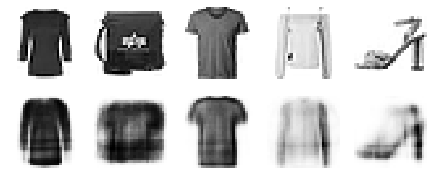

In [18]:
show_reconstructions(stacked_ae_1_by_1)

In [19]:
# re-compile the model with diffrent learning rate
stacked_ae_1_by_1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2864 - val_rounded_accuracy: 0.9365
Epoch 2/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9369
Epoch 3/10
55000/55000 [==============================] - 7s 133us/sample - loss: 0.2842 - rounded_accuracy: 0.9371 - val_loss: 0.2860 - val_rounded_accuracy: 0.9370
Epoch 4/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.2841 - rounded_accuracy: 0.9372 - val_loss: 0.2858 - val_rounded_accuracy: 0.9369
Epoch 5/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.2839 - rounded_accuracy: 0.9374 - val_loss: 0.2857 - val_rounded_accuracy: 0.9372
Epoch 6/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.2838 - rounded_accuracy: 0.9375 - val

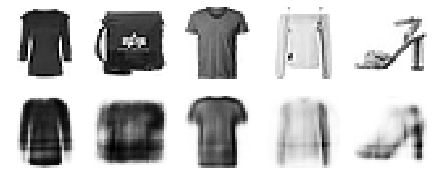

In [20]:
show_reconstructions(stacked_ae_1_by_1)

One of the triggers of the current tsunami of interest in Deep Learning was the discovery in 2006 by [Geoffrey Hinton et al](https://www.cs.toronto.edu/~hinton/absps/ncfast.pdf). that deep neural networks
can be pretrained in an unsupervised fashion, using this greedy layerwise
approach. They used restricted Boltzmann machines (RBMs) for this purpose, but in 2007 [Yoshua Bengio et al](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf). showed that autoencoders worked just as
well. 

For several years this was the only efficient way to train deep nets, until many of the techniques introduced, it possible to just train a deep net in
one shot.

